# Preparing the Dataset

In [205]:
import prepare_data
import pandas as pd
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import ast

In [232]:
def load_df(path,list_cols):
    df = pd.read_csv(path,sep="|")
    df[list_cols] = df[list_cols].applymap(
    lambda x: ast.literal_eval(x))
    return df

In [122]:
simple_path = "data/simple.aligned"
normal_path = "data/normal.aligned"

In [227]:
s_sent_col = "simple_sentence"
n_sent_col = "normal_sentence"

s_list_col = "s_sent"
s_pos_col = "s_pos"
n_list_col = "n_sent"
n_pos_col = "n_pos"
s_lem_col = "s_lem"
n_lem_col = "n_lem"

In [182]:
aligned_data = list(prepare_data.get_aligned_sentences(simple_path,normal_path))
df = prepare_data.create_df(aligned_data)

In [ ]:
#Tokenize the sentences
df[[s_sent_col,n_sent_col]] = df[[s_sent_col,n_sent_col]].applymap(lambda x: nltk.word_tokenize(x))

In [185]:
#Filter out sentences with no english word
df = df.loc[df[n_sent_col].apply(lambda x: len(set(x).intersection(english_df["word"].values))) > 0]
df = df.loc[df[s_sent_col].apply(lambda x: len(set(x).intersection(english_df["word"].values))) > 0]

In [186]:
#POS Tagging of sentences
df[[s_sent_col,n_sent_col]] = df[[s_sent_col,n_sent_col]].applymap(lambda x: list(zip(*nltk.pos_tag(x))))

In [187]:
#Divide created column into word and tag part
df["s_sent"] = df[[s_sent_col]].apply(lambda x: x[s_sent_col][0],axis=1)
df["s_pos"] = df[[s_sent_col]].apply(lambda x: x[s_sent_col][1],axis=1)
df["n_sent"] = df[[n_sent_col]].apply(lambda x: x[n_sent_col][0],axis=1)
df["n_pos"] = df[[n_sent_col]].apply(lambda x: x[n_sent_col][1],axis=1)

In [190]:
#Drop previous columns
df.drop([s_sent_col,n_sent_col],axis=1)

,simple_topic,simple_numb,normal_topic,normal_numb,s_sent,s_pos,n_sent,n_pos
0,"cherokee, oklahoma",0,"cherokee, oklahoma",0,"(cherokee, is, a, city, of, oklahoma, in, the,...","(NN, VBZ, DT, NN, IN, NN, IN, DT, JJ, NNS, .)","(cherokee, is, a, city, in, alfalfa, county, ,...","(NN, VBZ, DT, NN, IN, JJ, NN, ,, NN, ,, JJ, NN..."
1,skateboard,2,skateboard,5,"(skateboard, decks, are, normally, between, 28...","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","(skateboard, decks, are, usually, between, 28,...","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)"
2,skateboard,2,skateboard,5,"(the, bottom, of, the, deck, can, be, printed,...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","(the, underside, of, the, deck, can, be, print...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ..."
3,skateboard,3,skateboard,6,"(the, longboard, was, made, by, two, surfers, ...","(DT, NN, VBD, VBN, IN, CD, NNS, :, CC, NN, CC,...","(this, was, created, by, two, surfers, ;, ben,...","(DT, VBD, VBN, IN, CD, NNS, :, CC, NN, CC, JJ,..."
4,skateboard,2,skateboard,5,"(other, materials, used, in, making, decks, fi...","(JJ, NNS, VBN, IN, VBG, NNS, NN, ,, NN, ,, NN,...","(some, of, them, have, special, materials, tha...","(DT, IN, PRP, VBP, JJ, NNS, WDT, VBP, TO, VB, ..."
5,skateboard,3,skateboard,6,"(``, old, school, '', boards, -lrb-, those, ma...","(``, JJ, NN, '', NNS, VBP, DT, VBN, IN, DT, CD...","(``, old, school, '', boards, -lrb-, those, ma...","(``, JJ, NN, '', NNS, VBP, DT, VBN, IN, DT, CD..."
6,skateboard,4,skateboard,7,"(grip, tape, ,, when, put, on, to, the, top, o...","(NN, NN, ,, WRB, VBN, IN, TO, DT, NN, IN, DT, ...","(grip, tape, ,, when, applied, to, the, top, s...","(NN, NN, ,, WRB, VBN, TO, DT, JJ, NN, IN, DT, ..."
7,skateboard,2,skateboard,5,"(modern, decks, are, different, in, size, ., m...","(JJ, NNS, VBP, JJ, IN, NN, ., RBS, VBP, CD, TO...","(modern, decks, vary, in, size, ,, but, most, ...","(JJ, NNS, VBP, IN, NN, ,, CC, JJS, VBP, CD, TO..."
8,skateboard,3,skateboard,6,"(different, kinds, of, the, 1970s, often, have...","(JJ, NNS, IN, DT, NNS, RB, VBP, JJ, CC, DT, NN...","(variants, of, the, 1970s, often, have, little...","(NNS, IN, DT, NNS, RB, VBP, JJ, CC, DT, NN, ,,..."
9,skateboard,1,skateboard,4,"(the, normal, parts, to, made, a, complete, sk...","(DT, JJ, NNS, TO, VB, DT, JJ, NN, VBP, DT, NN,...","(the, usual, parts, to, design, a, complete, s...","(DT, JJ, NNS, TO, VB, DT, JJ, NN, VBP, DT, NN,..."


In [191]:
df = df.drop([s_sent_col,n_sent_col],axis=1)

In [192]:
#Save Corpus to file
df.to_csv("data/wikipedia_aligned_pos.csv",index=False,sep="|")

In [ ]:
df = pd.DataFrame.from_csv("data/wikipedia_aligned_pos.csv",sep="|")
df.head()

In [213]:
df[[s_list_col,s_pos_col,n_list_col,n_pos_col]] = df[[s_list_col,s_pos_col,n_list_col,n_pos_col]].applymap(
    lambda x: ast.literal_eval(x))

In [214]:
df.iloc[0][s_list_col]

('cherokee',
 'is',
 'a',
 'city',
 'of',
 'oklahoma',
 'in',
 'the',
 'united',
 'states',
 '.')

# Lemmatizing

In [221]:
 def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [195]:
lemmatizer = WordNetLemmatizer()

In [224]:
s_lemmatized = df.apply(lambda x: [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) for word,tag in zip(*[x["s_sent"],x["s_pos"]])],axis=1)
n_lemmatized = df.apply(lambda x: [lemmatizer.lemmatize(word,get_wordnet_pos(tag)) for word,tag in zip(*[x["n_sent"],x["n_pos"]])],axis=1)

In [225]:
df[s_lem_col] = s_lemmatized
df[n_lem_col] = n_lemmatized

In [228]:
df = df.drop([s_sent_col,n_sent_col])
df.to_csv("data/wikipedia_aligned_lem.csv",index=False,sep="|")

# Feature Implementation

In [233]:
df = load_df("data/wikipedia_aligned_lem.csv",[s_lem_col,n_lem_col,s_pos_col,n_pos_col])

In [234]:
df.head()

,simple_numb,normal_topic,normal_numb,s_sent,s_pos,n_sent,n_pos,s_lem,n_lem
0,0,"cherokee, oklahoma",0,"('cherokee', 'is', 'a', 'city', 'of', 'oklahom...","(NN, VBZ, DT, NN, IN, NN, IN, DT, JJ, NNS, .)","('cherokee', 'is', 'a', 'city', 'in', 'alfalfa...","(NN, VBZ, DT, NN, IN, JJ, NN, ,, NN, ,, JJ, NN...","[cherokee, be, a, city, of, oklahoma, in, the,...","[cherokee, be, a, city, in, alfalfa, county, ,..."
1,2,skateboard,5,"('skateboard', 'decks', 'are', 'normally', 'be...","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","('skateboard', 'decks', 'are', 'usually', 'bet...","(NN, NNS, VBP, RB, IN, CD, CC, CD, NNS, RB, .)","[skateboard, deck, be, normally, between, 28, ...","[skateboard, deck, be, usually, between, 28, a..."
2,2,skateboard,5,"('the', 'bottom', 'of', 'the', 'deck', 'can', ...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","('the', 'underside', 'of', 'the', 'deck', 'can...","(DT, NN, IN, DT, NN, MD, VB, VBN, IN, DT, NN, ...","[the, bottom, of, the, deck, can, be, print, w...","[the, underside, of, the, deck, can, be, print..."
3,3,skateboard,6,"('the', 'longboard', 'was', 'made', 'by', 'two...","(DT, NN, VBD, VBN, IN, CD, NNS, :, CC, NN, CC,...","('this', 'was', 'created', 'by', 'two', 'surfe...","(DT, VBD, VBN, IN, CD, NNS, :, CC, NN, CC, JJ,...","[the, longboard, be, make, by, two, surfer, ;,...","[this, be, create, by, two, surfer, ;, ben, wh..."
4,2,skateboard,5,"('other', 'materials', 'used', 'in', 'making',...","(JJ, NNS, VBN, IN, VBG, NNS, NN, ,, NN, ,, NN,...","('some', 'of', 'them', 'have', 'special', 'mat...","(DT, IN, PRP, VBP, JJ, NNS, WDT, VBP, TO, VB, ...","[other, material, use, in, make, deck, fibergl...","[some, of, them, have, special, material, that..."


## Word and Sentence Length

In [ ]:
def pos_tagging(sentence):
    np.array(sentence).vectorize(lambda x: nltk.pos_tag())

In [78]:
def count_sent_word_length(df):
    df[["simple_sentence","normal_sentence"]] = df[["simple_sentence","normal_sentence"]].applymap(lambda x: nltk.word_tokenize(x))
    
    df[[n_sent_col,s_sent_col]] = df[[n_sent_col,s_sent_col]].applymap(lambda x: lemmatizer.lemmatize(x))
    len_mean_sents = df[["simple_sentence","normal_sentence"]].applymap(lambda x: (len(x),np.mean([len(word) for word in x])))
    df[['s_sent_len', 's_word_mean']] = len_mean_sents["simple_sentence"].apply(pd.Series)
    df[['n_sent_len', 'n_word_mean']] = len_mean_sents["normal_sentence"].apply(pd.Series)
    return df

In [79]:
df = count_sent_word_length(df)

In [80]:
df.head()

,simple_topic,simple_numb,simple_sentence,normal_topic,normal_numb,normal_sentence,s_sent_len,s_word_mean,n_sent_len,n_word_mean
0,"cherokee, oklahoma",0,"[cherokee, is, a, city, of, oklahoma, in, the,...","cherokee, oklahoma",0,"[cherokee, is, a, city, in, alfalfa, county, ,...",11.0,3.909091,13.0,4.076923
1,skateboard,2,"[skateboard, decks, are, normally, between, 28...",skateboard,5,"[skateboard, decks, are, usually, between, 28,...",11.0,4.636364,11.0,4.545455
2,skateboard,2,"[the, bottom, of, the, deck, can, be, printed,...",skateboard,5,"[the, underside, of, the, deck, can, be, print...",21.0,3.190476,24.0,3.958333
3,skateboard,3,"[the, longboard, was, made, by, two, surfers, ...",skateboard,6,"[this, was, created, by, two, surfers, ;, ben,...",14.0,4.142857,13.0,4.076923
4,skateboard,2,"[other, materials, used, in, making, decks, fi...",skateboard,5,"[some, of, them, have, special, materials, tha...",22.0,4.272727,33.0,4.030303


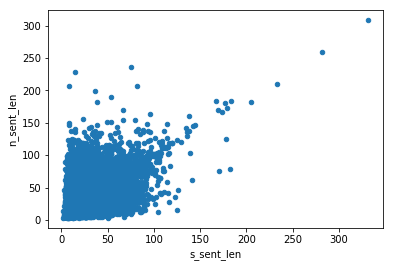

In [49]:
df.plot.scatter(x="s_sent_len",y="n_sent_len")

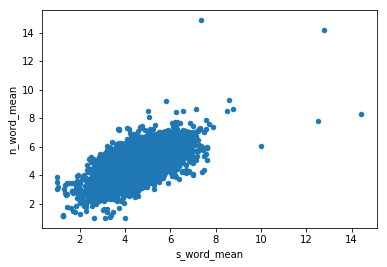

In [50]:
df.plot.scatter(x="s_word_mean",y="n_word_mean")

## Basic English

In [68]:
with open("data/basic_english.txt","r") as f:
    data = f.read()
    words = data.split(" , ")
    basic_df = pd.DataFrame(data=words,columns=["word"])
    basic_df["index"] = range(0,len(basic_df))
basic_df.head()

,word,index
0,a,0
1,able,1
2,about,2
3,account,3
4,acid,4


In [111]:
with open("data/20k_words.txt","r") as f:
    data = f.read()
    words = data.split("\n")
    english_df = pd.DataFrame(data=words,columns=["word"])
    english_df["index"] = range(0,len(english_df))
    non_basic_df = english_df.loc[~english_df["word"].isin(basic_df["word"])]
non_basic_df.head(10)

,word,index
7,is,7
10,by,10
13,i,13
15,it,15
18,be,18
19,are,19
23,your,23
27,more,27
28,an,28
29,was,29


In [130]:
#how many words are not in the basic english
df[["n_non_basic_freq","s_non_basic_freq"]] = df[[n_sent_col,s_sent_col]].applymap(
    lambda x: len(set(x).intersection(
        non_basic_df["word"].values))/len(set(x).intersection(
        english_df["word"].values)))

In [116]:
drop_bool = df[n_sent_col].apply(lambda x: len(set(x).intersection(english_df["word"].values))) == 0

In [103]:
set([1,2,3]).intersection(set([3,4,5])).difference(set([4,5]))

{3}

In [132]:
df.iloc[2]

simple_topic                                               skateboard
simple_numb                                                         2
simple_sentence     the bottom of the deck can be printed with a d...
normal_topic                                               skateboard
normal_numb                                                         5
normal_sentence     the underside of the deck can be printed with ...
n_non_basic_freq                                             0.952381
s_non_basic_freq                                                 0.95
Name: 2, dtype: object

In [135]:
basic_df.loc[basic_df["word"] == "printed"]

,word,index
